<a href="https://colab.research.google.com/github/Pushpaja-Udayagiri/Rag-weather-Predict/blob/main/Predict_weather_using_RAG!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting weather in the next hour using raw data

This notebook demonstrates how we can use vector search for time series forecasting on climate data with Pinecone.
We use the [Jena Climate dataset](https://www.kaggle.com/stytch16/jena-climate-2009-2016) for this example. Jena Climate dataset is made up of quantities such as air temperature, atmospheric pressure, humidity, wind direction, etc. that were recorded every 10 minutes, over several years.

In a tabular dataset like this, every column can be seen as a feature vector identified uniquely by the time stamp associated with them. We can use these vectors to perform similarity search with a given query vector at a certain time to predict the weather for that hour. Though a very simple embedding extraction process, we want to see how far we can get even with a basic similarity search method like this. We will see how to do with Pinecone in the steps below.



### Install Pinecone




In [2]:
!pip install \
    pinecone-client \
    matplotlib \
    tensorflow \
    scikit-learn \
    pandas \
    tqdm \
    pinecone-notebooks


In [10]:
!pip uninstall -y pinecone-client
!pip install pinecone


Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 6.2 MB/s eta 0:00:00


You can get your Pinecone API Key [here](https://www.pinecone.io/start/) if you don't have one.

In [9]:
import os

# initialize connection to pinecone (orget API key at app.pinecone.io)
if not os.environ.get("pcsk_4LzCa_MdMHTYABAXGoTNx35AWq4PMLs9iLio8PmFxUZbShD7GUgH9awfxmstvnk3CnF9j"):
    from pinecone_notebooks.colab import Authenticate
    Authenticate()

In [11]:
from pinecone import Pinecone
import os

# Initialize connection to Pinecone (get API key at app.pinecone.io)
api_key = os.environ.get("PINECONE_API_KEY") or "your-api-key"

# Configure client
pc = Pinecone(api_key=api_key)


Now we setup our index specification, this allows us to define the cloud provider and region where we want to deploy our index. You can find a list of all [available providers and regions here](https://docs.pinecone.io/docs/projects).

In [12]:
from pinecone import ServerlessSpec

cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

### Import other dependencies

In [13]:
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import List
import itertools

mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False

### Load the dataset

In [19]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)

# Get the correct path of the extracted CSV file
extracted_dir = os.path.splitext(zip_path)[0]  # This is the extracted directory
csv_path = os.path.join(extracted_dir, "jena_climate_2009_2016.csv")  # Full CSV file path


Load the hourly data into a dataframe

In [20]:
original_data_for_insert = pd.read_csv(csv_path)
original_data_for_insert = original_data_for_insert[5::6]

original_data_for_insert['Date Time'] = pd.to_datetime(original_data_for_insert['Date Time'], format='%d.%m.%Y %H:%M:%S')

Split data into data that is going to be inserted into Pinecone, and data that is going to be used for querying.

In [23]:
n = len(original_data_for_insert)
train_data = original_data_for_insert[:int(n*0.9)]
test_data = original_data_for_insert[int(n*0.9):]


Let's see what the data looks like.

In [25]:
train_data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Prepare data for upload. We will be querying data by the date and time.

In [26]:
items_to_upload = []
for row in train_data.values.tolist():
    key = str(row[0])
    values = row[1:]
    items_to_upload.append((key, values))

Prepare data that is going to be queried.
Here we create two lists - one with dates that are going to be queried and the other one with vectors.



In [27]:
query_dates = []
query_data = []
for row in test_data.values.tolist():
    query_dates.append(str(row[0]))
    query_data.append(row[1:])

### Setting up an index

In [28]:
# Pick a name for the new service
index_name = 'time-series-weather'

In [29]:
import time

# check if index already exists (it shouldn't if this is first time)
if index_name not in pc.list_indexes().names():
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=14,
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
# view index stats
index.describe_index_stats()

{'dimension': 14,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {},
 'total_vector_count': 0,
 'vector_type': 'dense'}

In [30]:
# Upload items
def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

for batch in chunks(items_to_upload, 500):
    index.upsert(vectors=batch)

In [31]:
# Check the index size to confirm the data was upserted properly
index.describe_index_stats()

{'dimension': 14,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 64476}},
 'total_vector_count': 64476,
 'vector_type': 'dense'}

In [32]:
from tqdm.auto import tqdm

# Query items
all_query_results = []
for xq in tqdm(query_data):
    res = index.query(vector=xq, top_k=1)
    all_query_results.append(res)

  0%|          | 0/7010 [00:00<?, ?it/s]

Here we create a function for getting predictions from Pinecone. We do this by using vectors to find the most similar vector in the index and then reading the hour after that.

In [33]:
def get_predictions(feature: str) -> (List, List):

    true_values = []
    predicted_values = []

    for test_date, qr in zip(query_dates, all_query_results):
        similar_date = [res.id for res in qr.matches][0]
        hour_from_original = datetime.strptime(str(test_date), '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)
        hour_from_similar = datetime.strptime(similar_date, '%Y-%m-%d %H:%M:%S') + timedelta(hours=1)

        original_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_original][feature].tolist()
        similar_temperature = original_data_for_insert.loc[original_data_for_insert['Date Time'] == hour_from_similar][feature].tolist()

        if original_temperature and similar_temperature:
            true_values.append(original_temperature[0])
            predicted_values.append(similar_temperature[0])
    return true_values, predicted_values


In [34]:
def plot_results(predicted_values: List, true_values: List):
    x_list = range(0, len(predicted_values))
    plt.plot(x_list[:200], predicted_values[:200], label='forecast')
    plt.plot(x_list[:200], true_values[:200], label='true')
    plt.legend()
    plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def print_results(true_values: List, predicted_values: List):
    print(f'MSE: {mean_squared_error(true_values, predicted_values)}')
    print(f'RMSE: {mean_squared_error(true_values, predicted_values, squared=False)}')
    print(f'MAE: {mean_absolute_error(true_values, predicted_values)}')

In [41]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(true_values, predicted_values)  # Remove squared=False
  # This line


In [39]:
import sklearn
print(sklearn.__version__)


1.6.1


### Results

To evaluate our results we will plot the predicted and true values for all the 14 features.

Analyzing predictions for p (mbar)


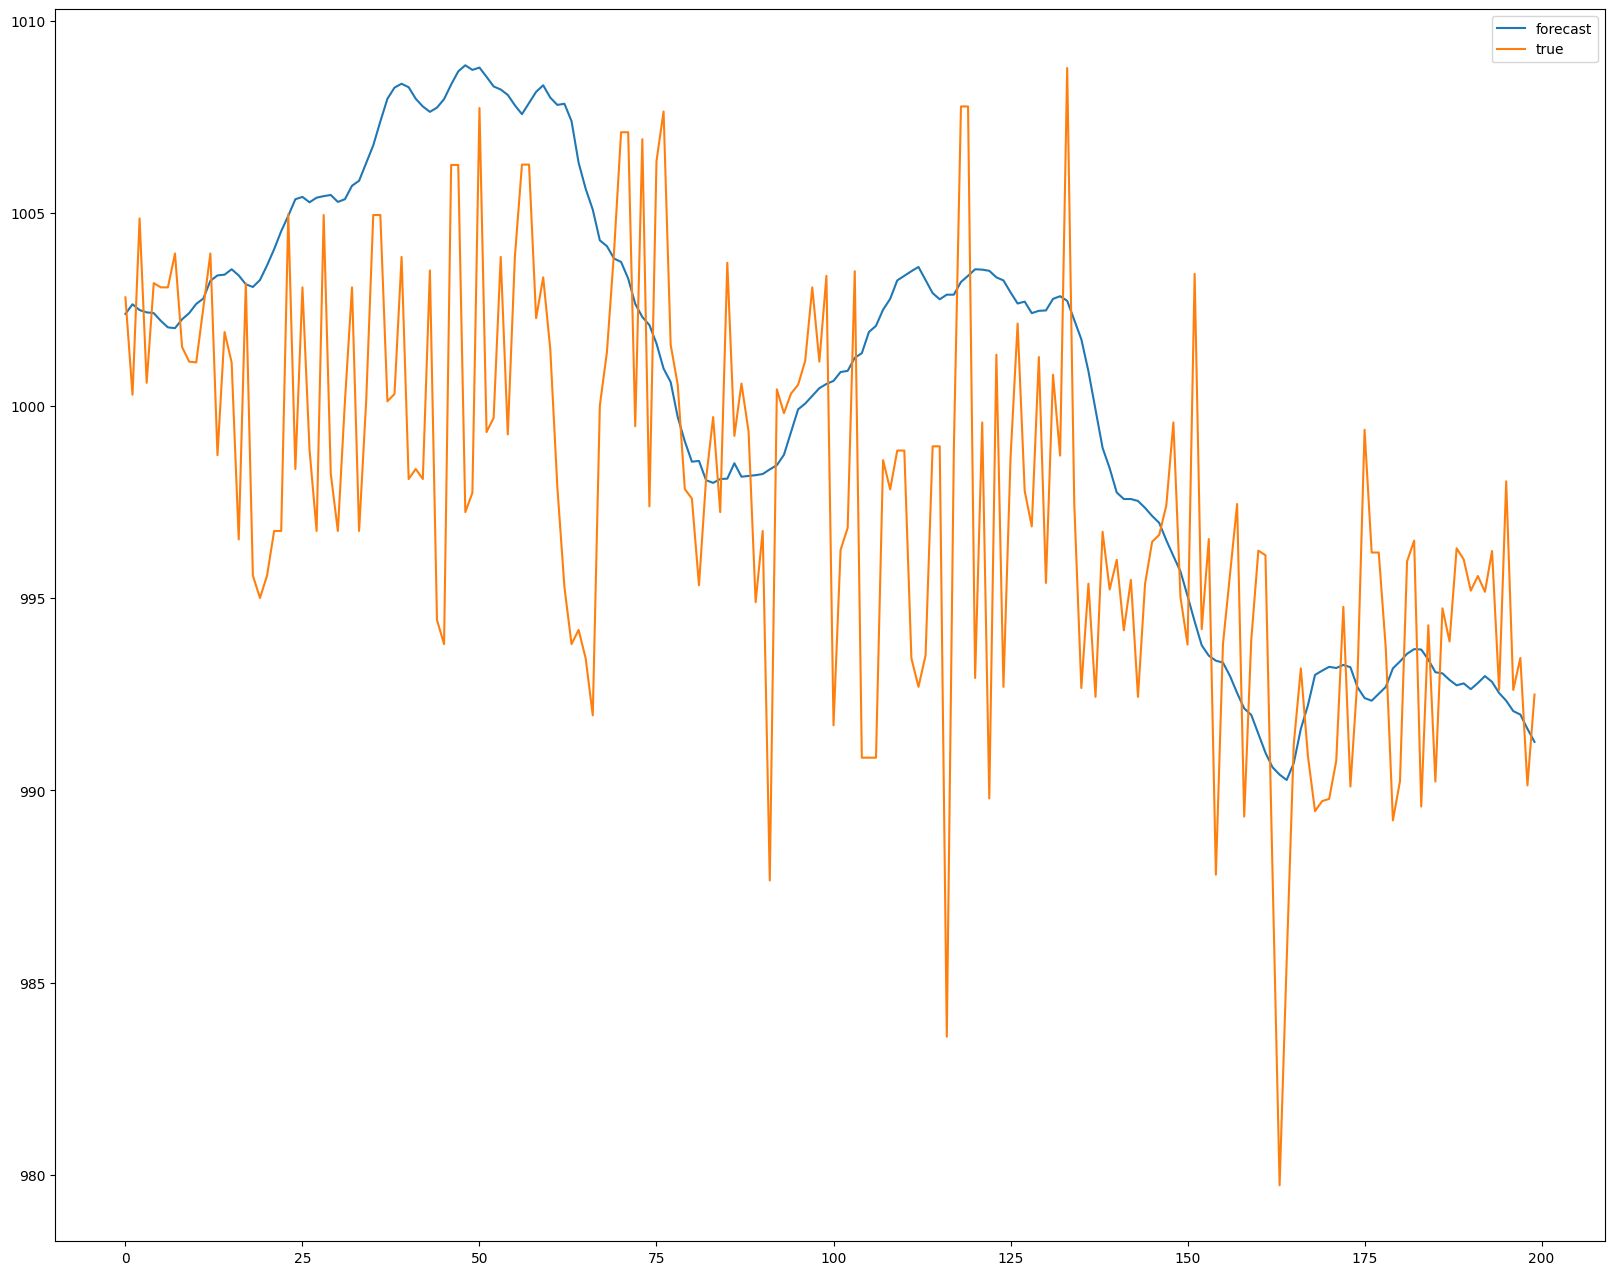

Analyzing predictions for T (degC)


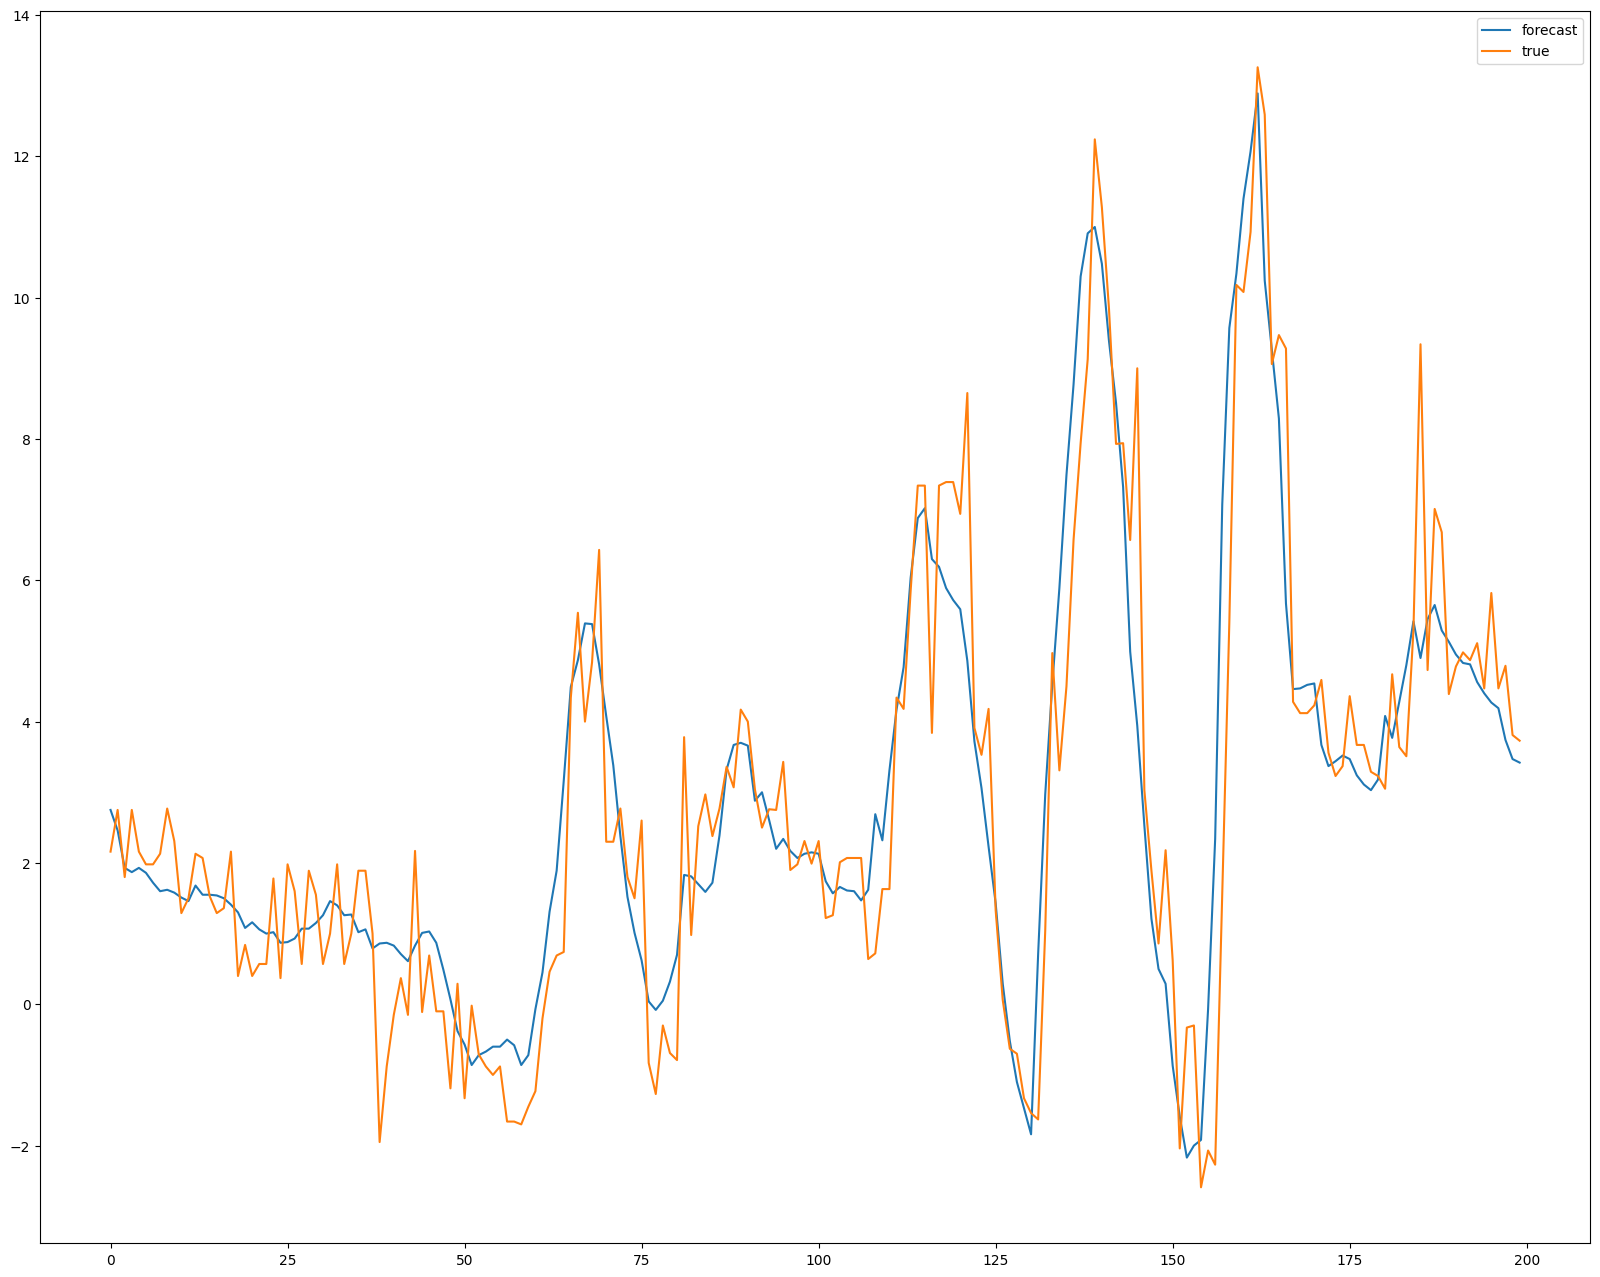

Analyzing predictions for Tpot (K)


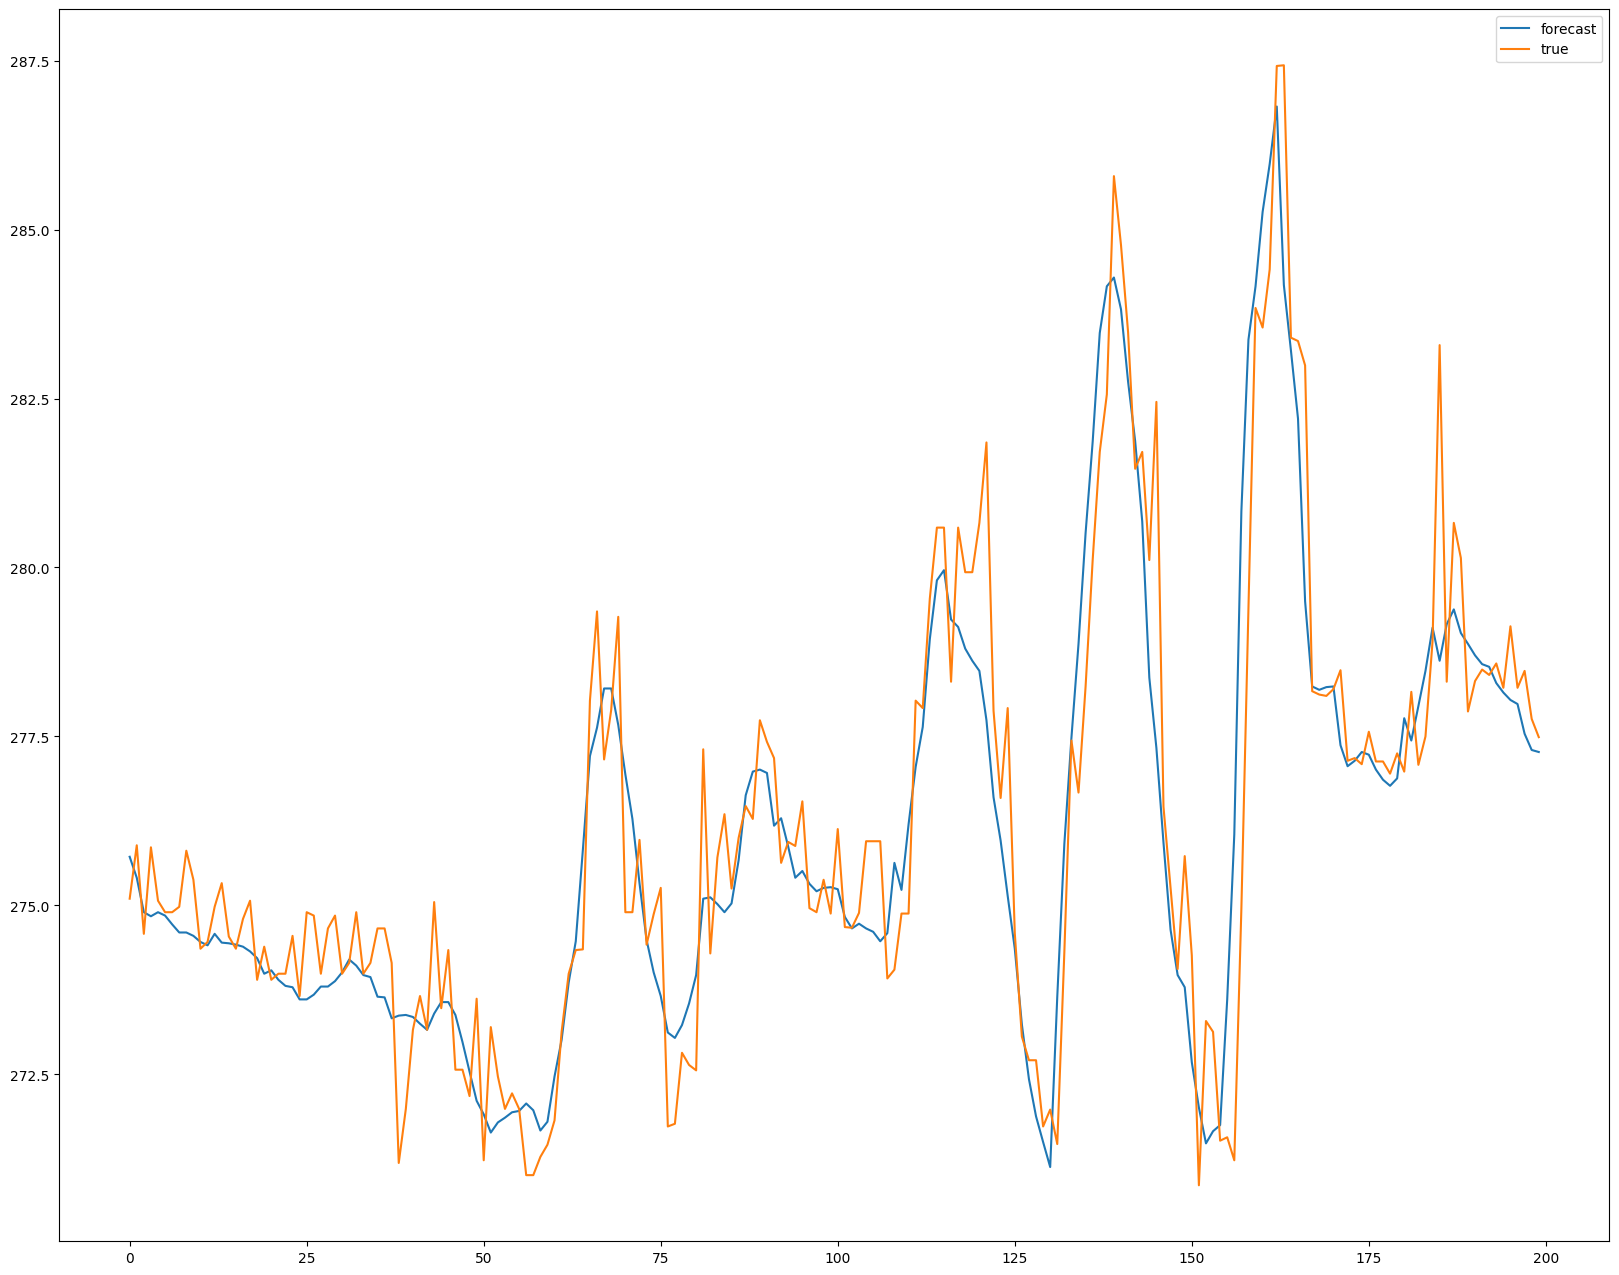

Analyzing predictions for Tdew (degC)


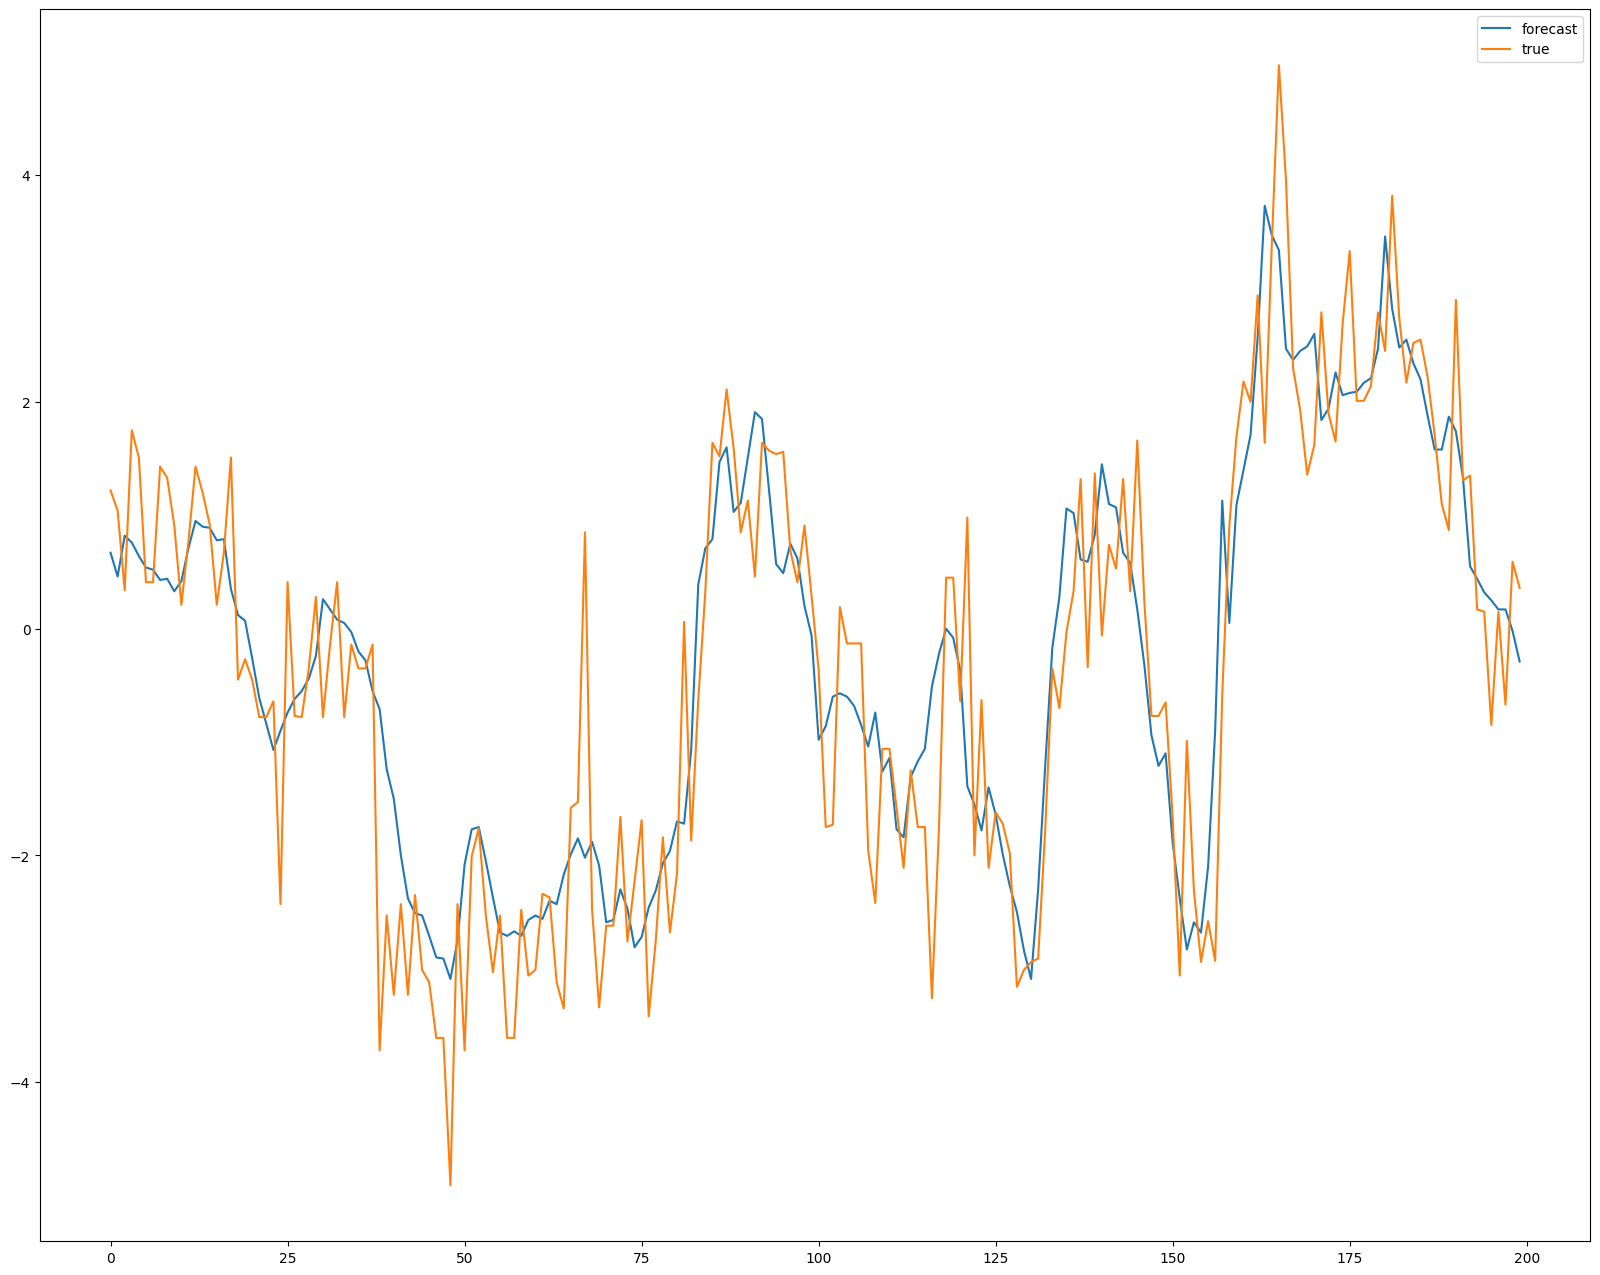

Analyzing predictions for rh (%)


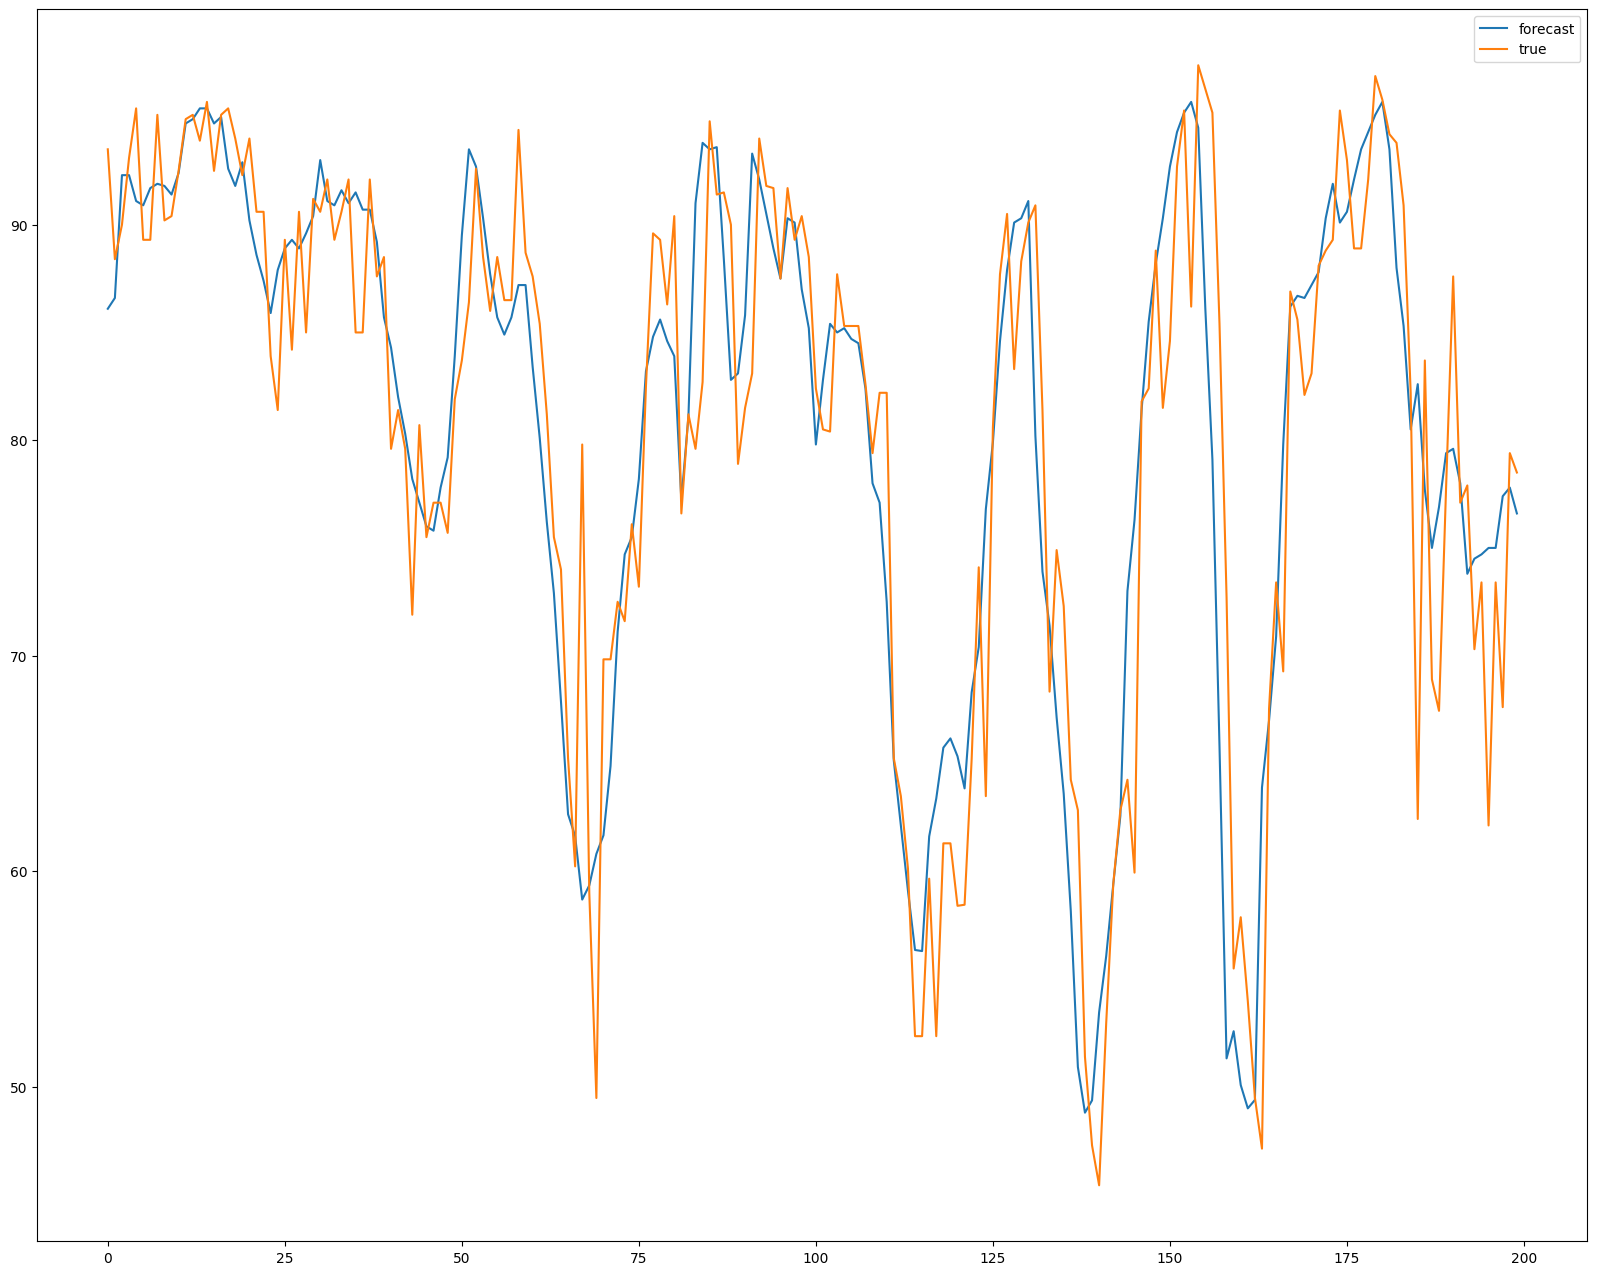

Analyzing predictions for VPmax (mbar)


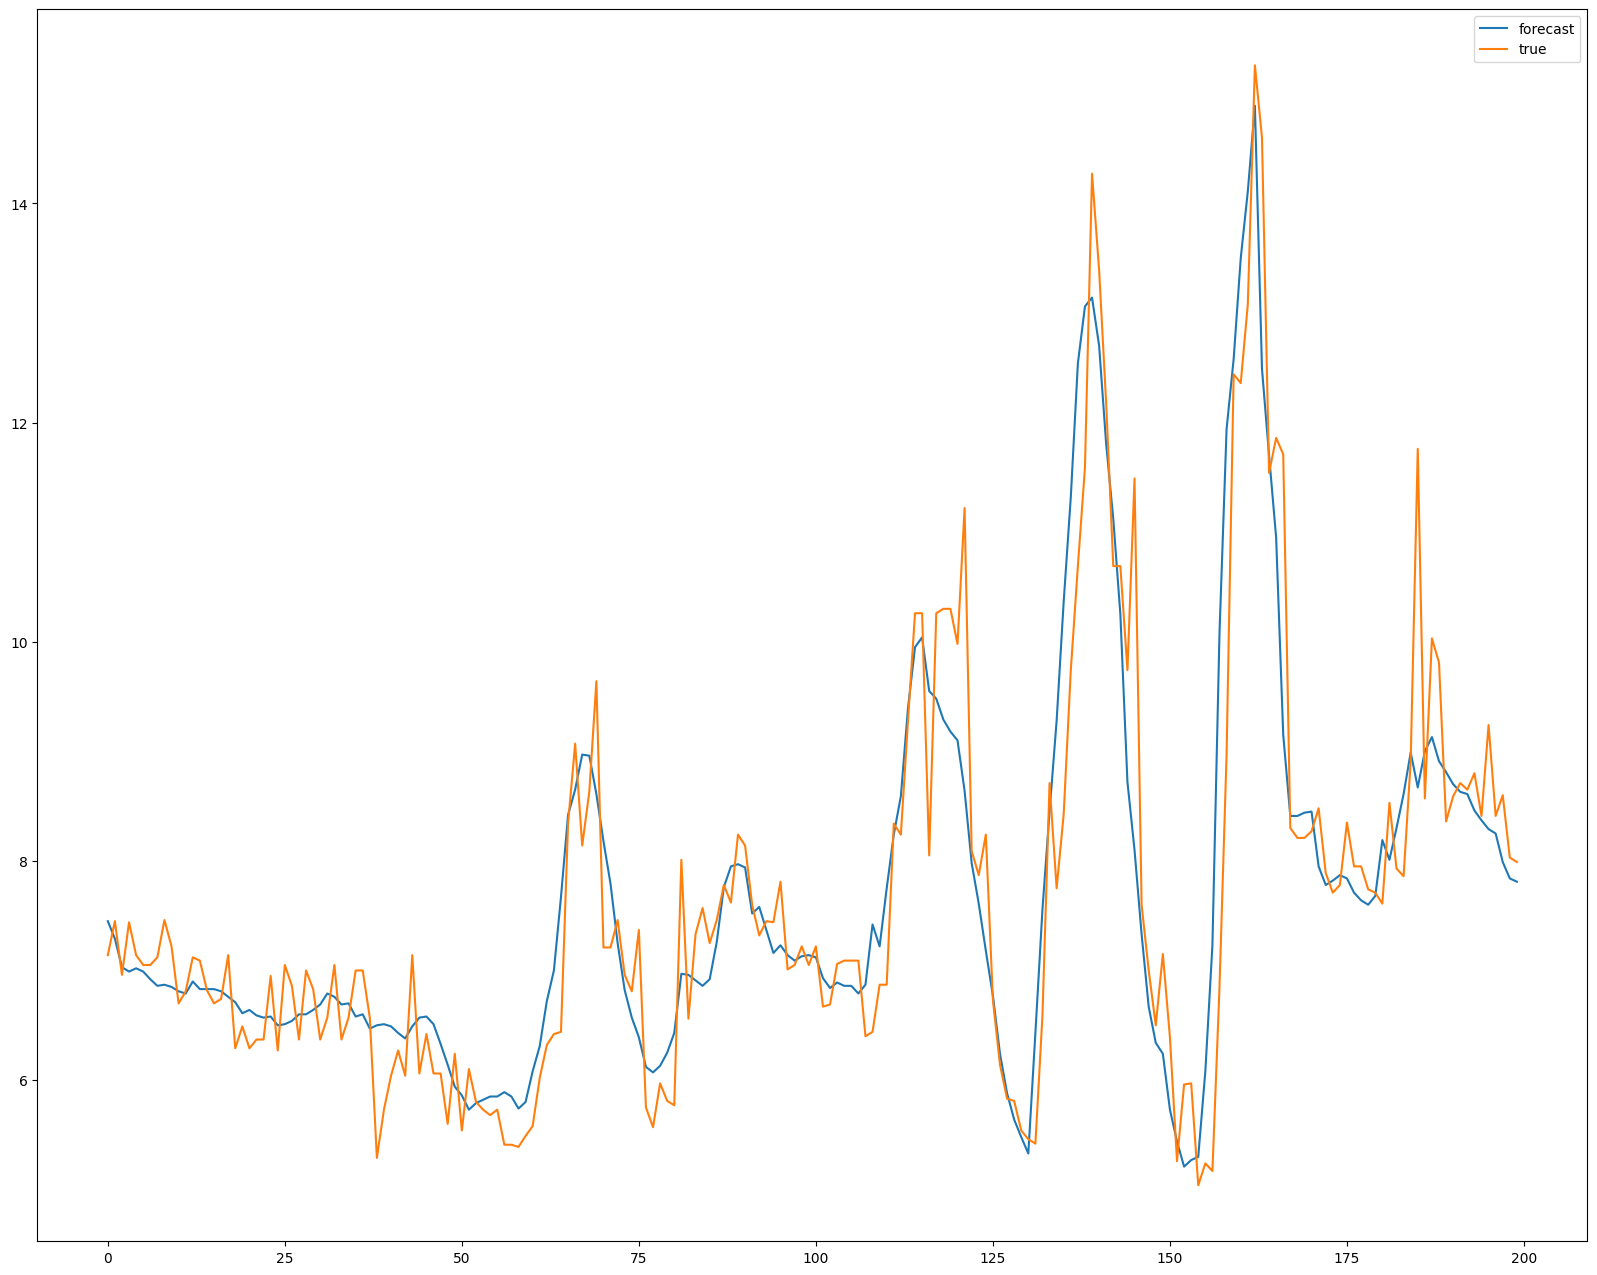

Analyzing predictions for VPact (mbar)


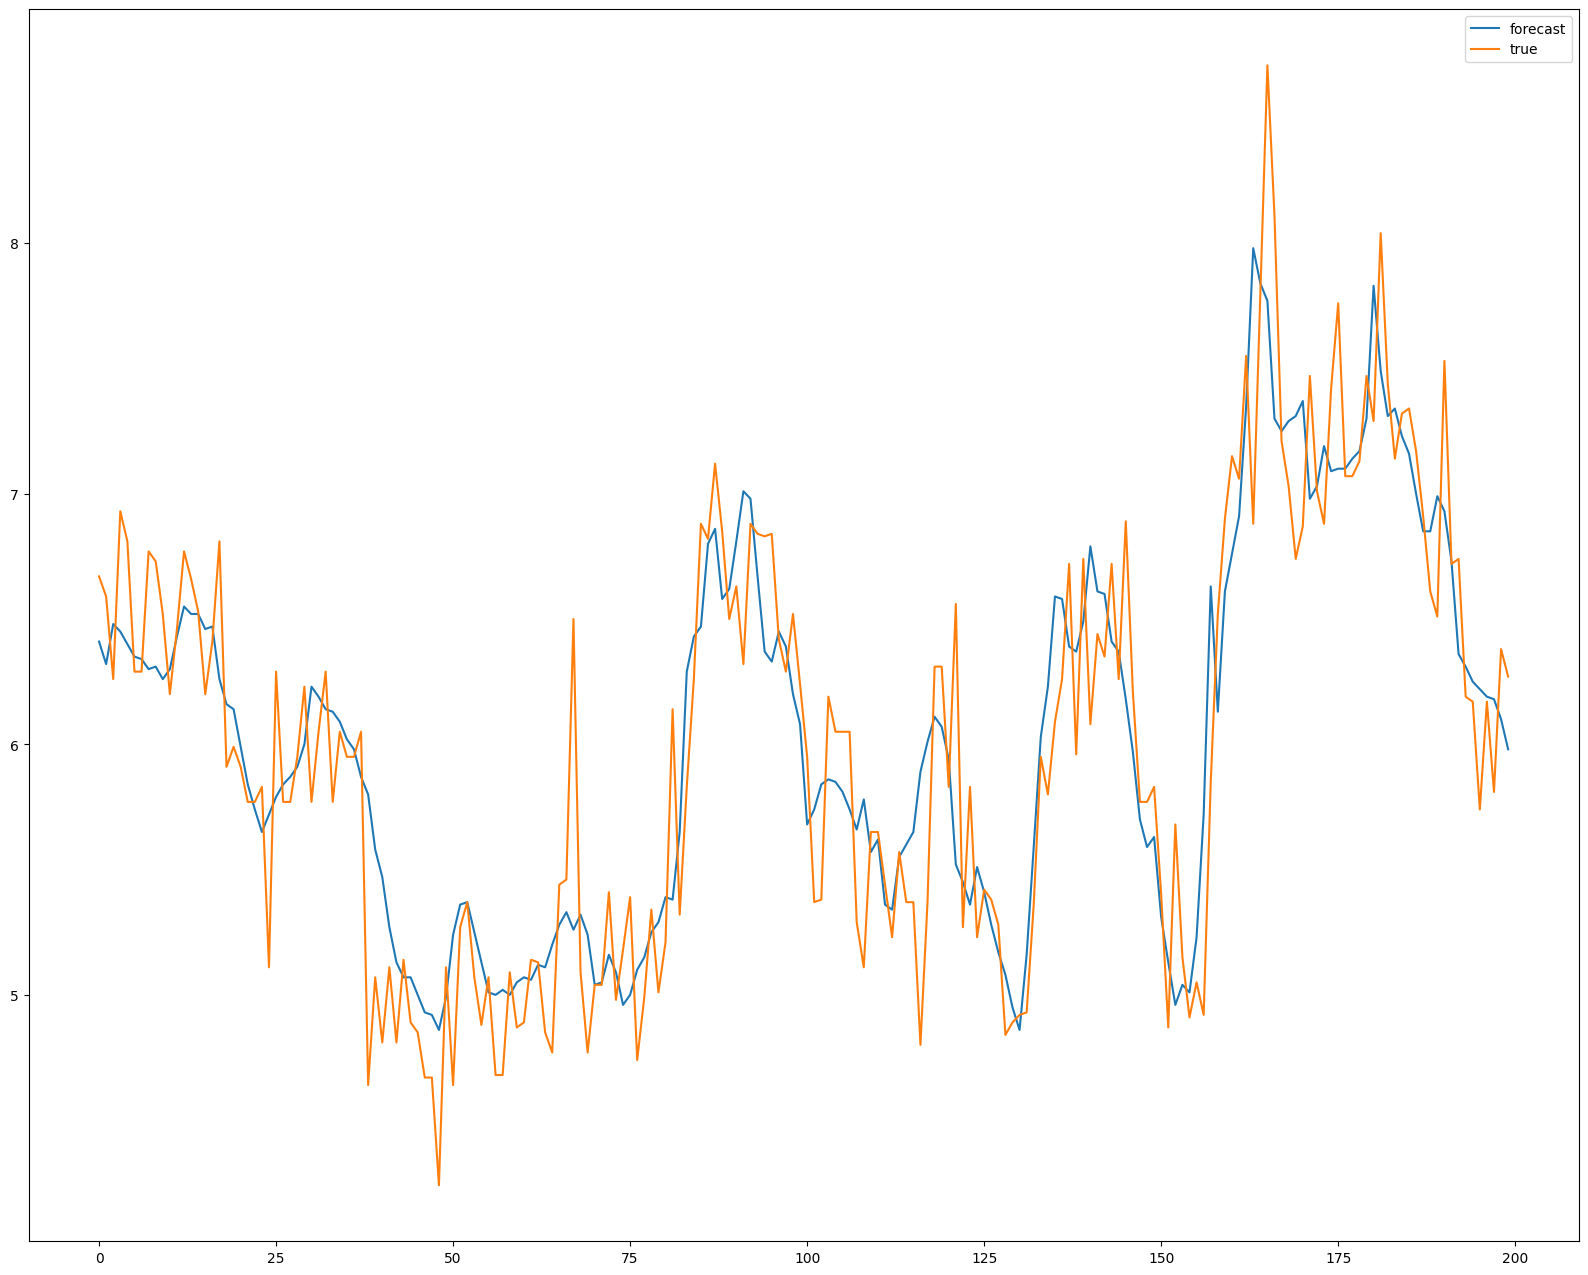

Analyzing predictions for VPdef (mbar)


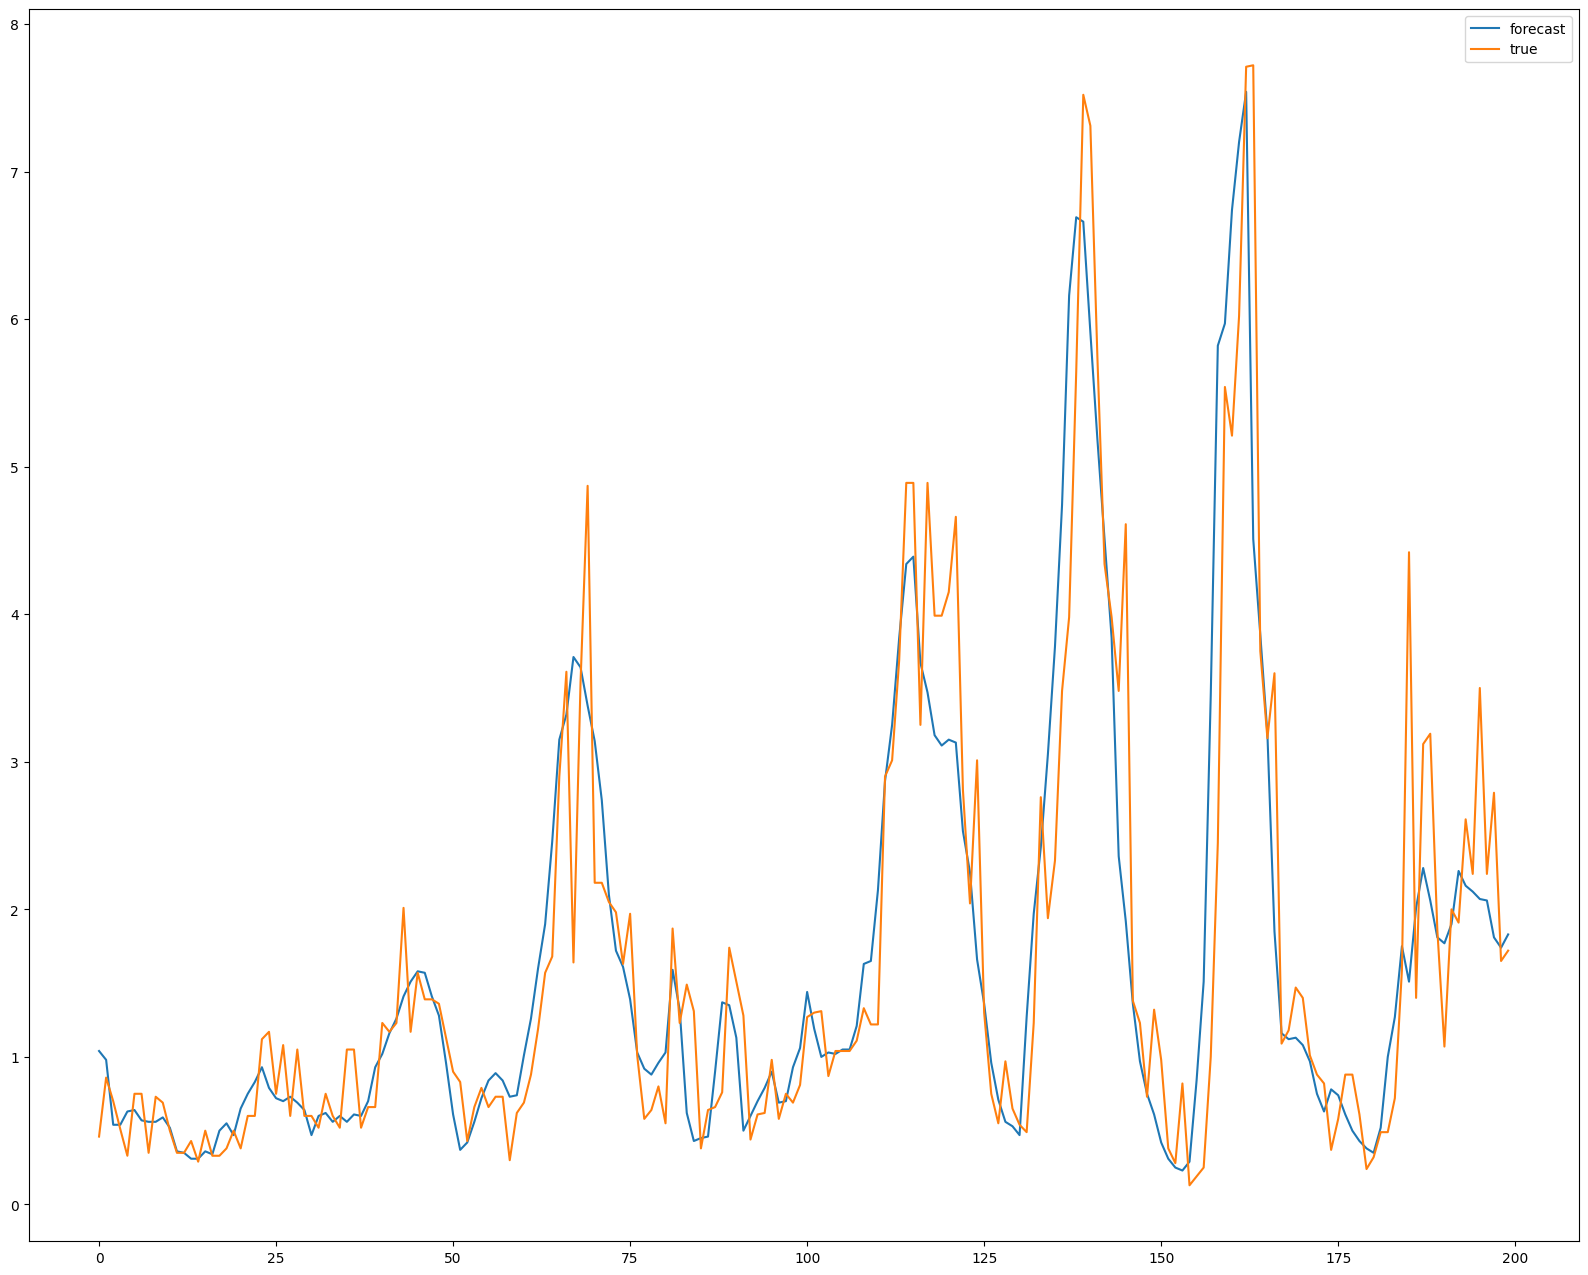

Analyzing predictions for sh (g/kg)


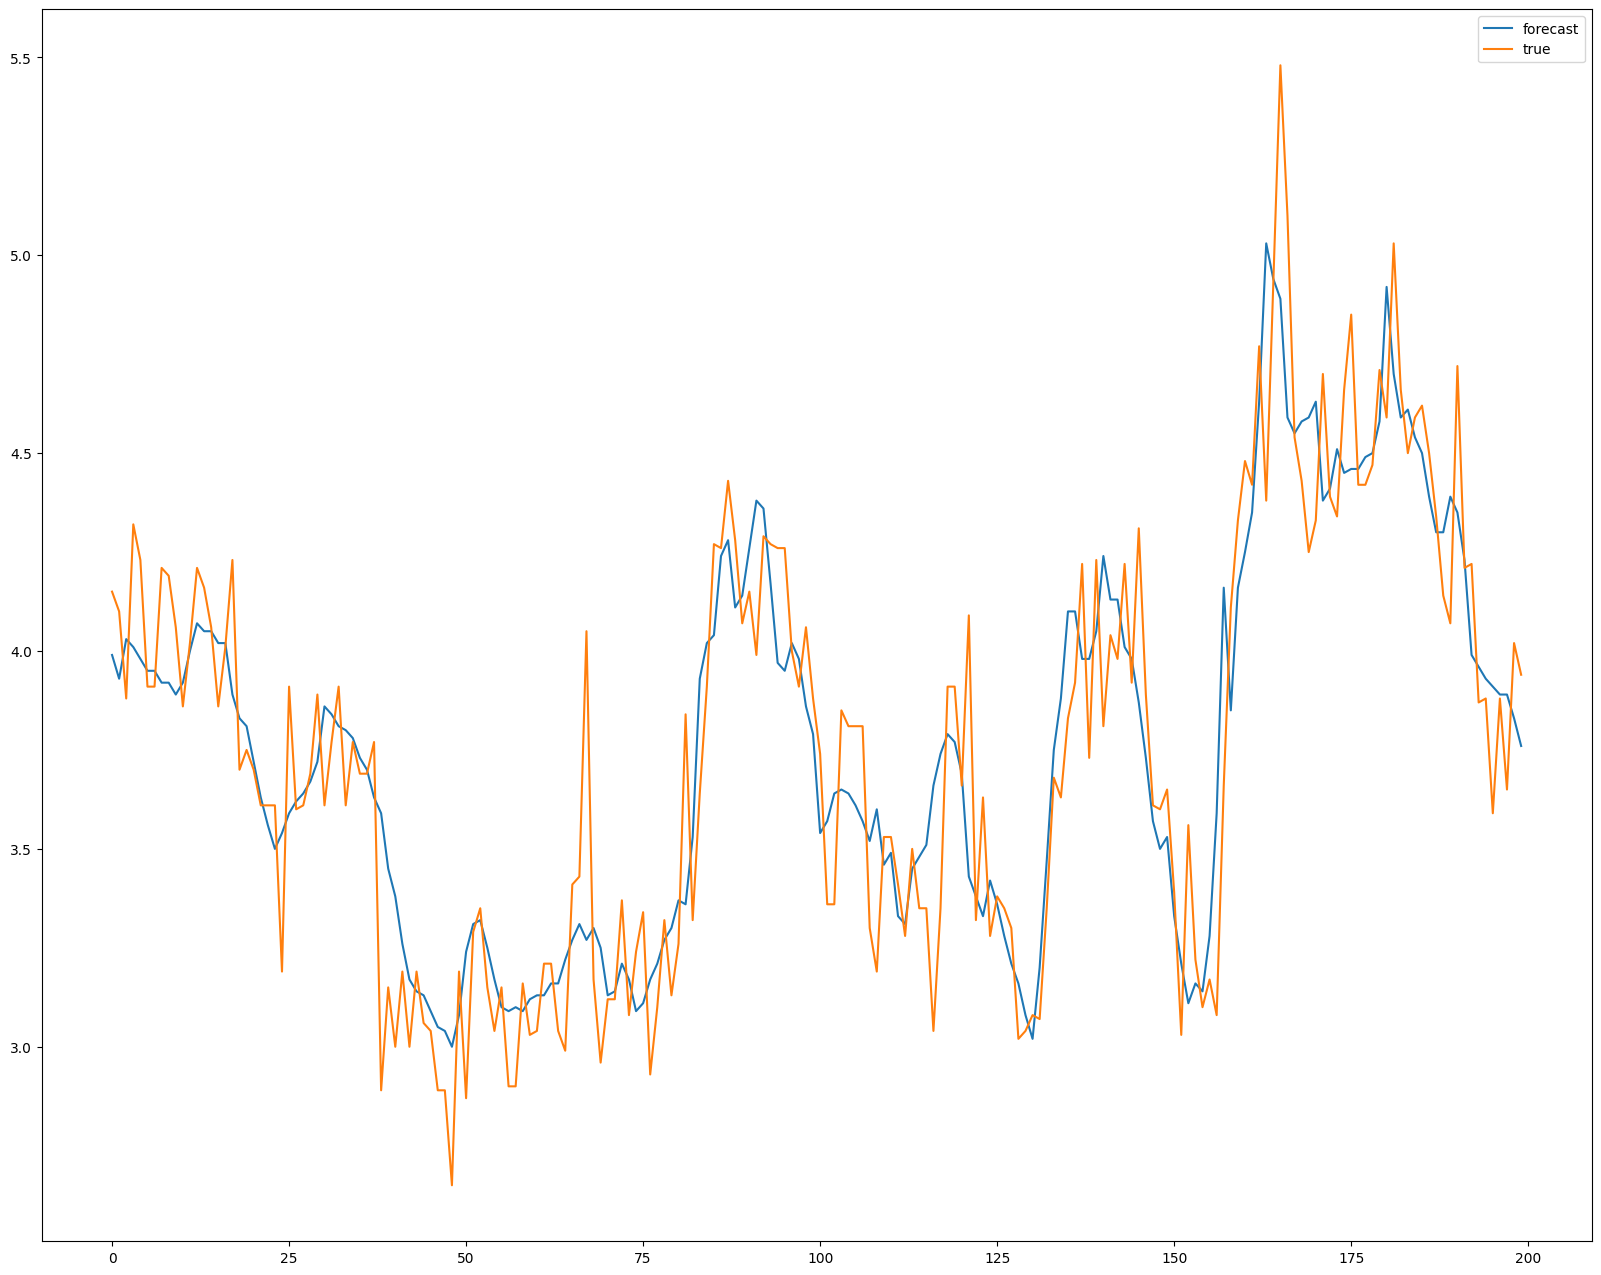

Analyzing predictions for H2OC (mmol/mol)


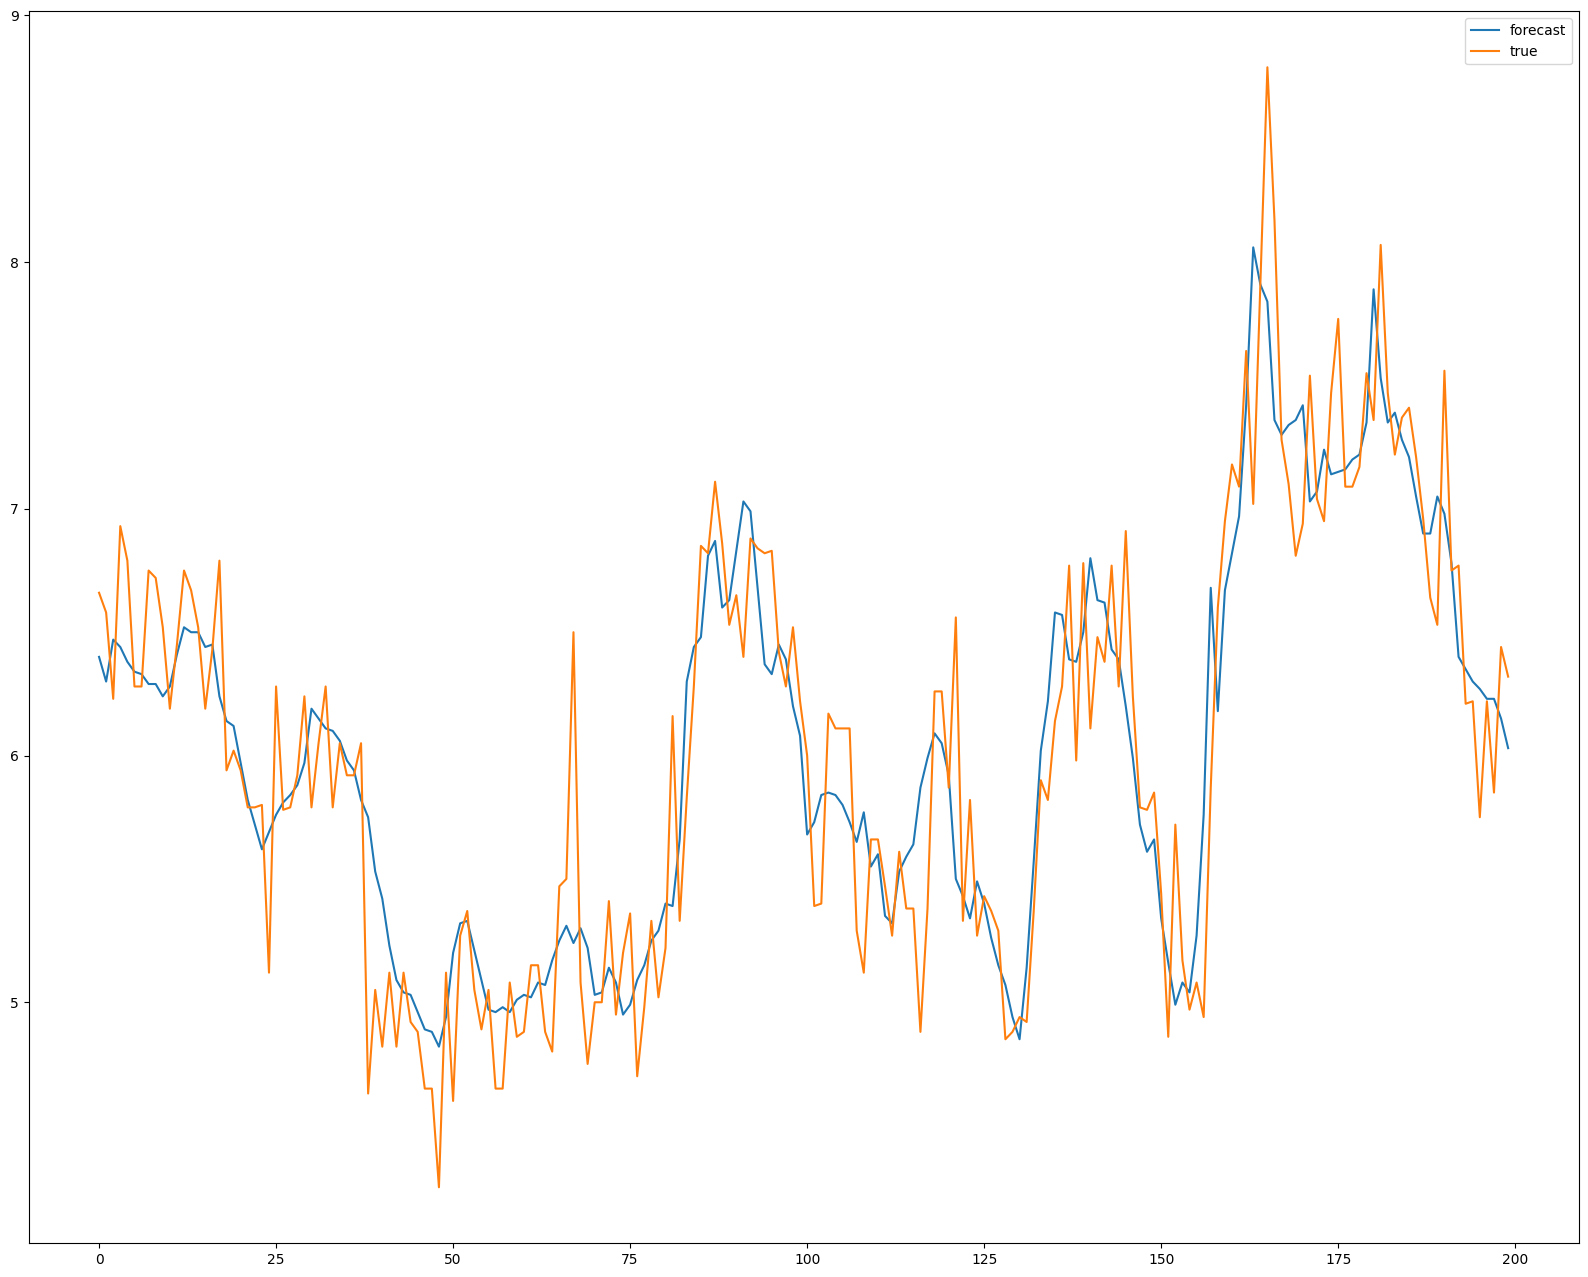

Analyzing predictions for rho (g/m**3)


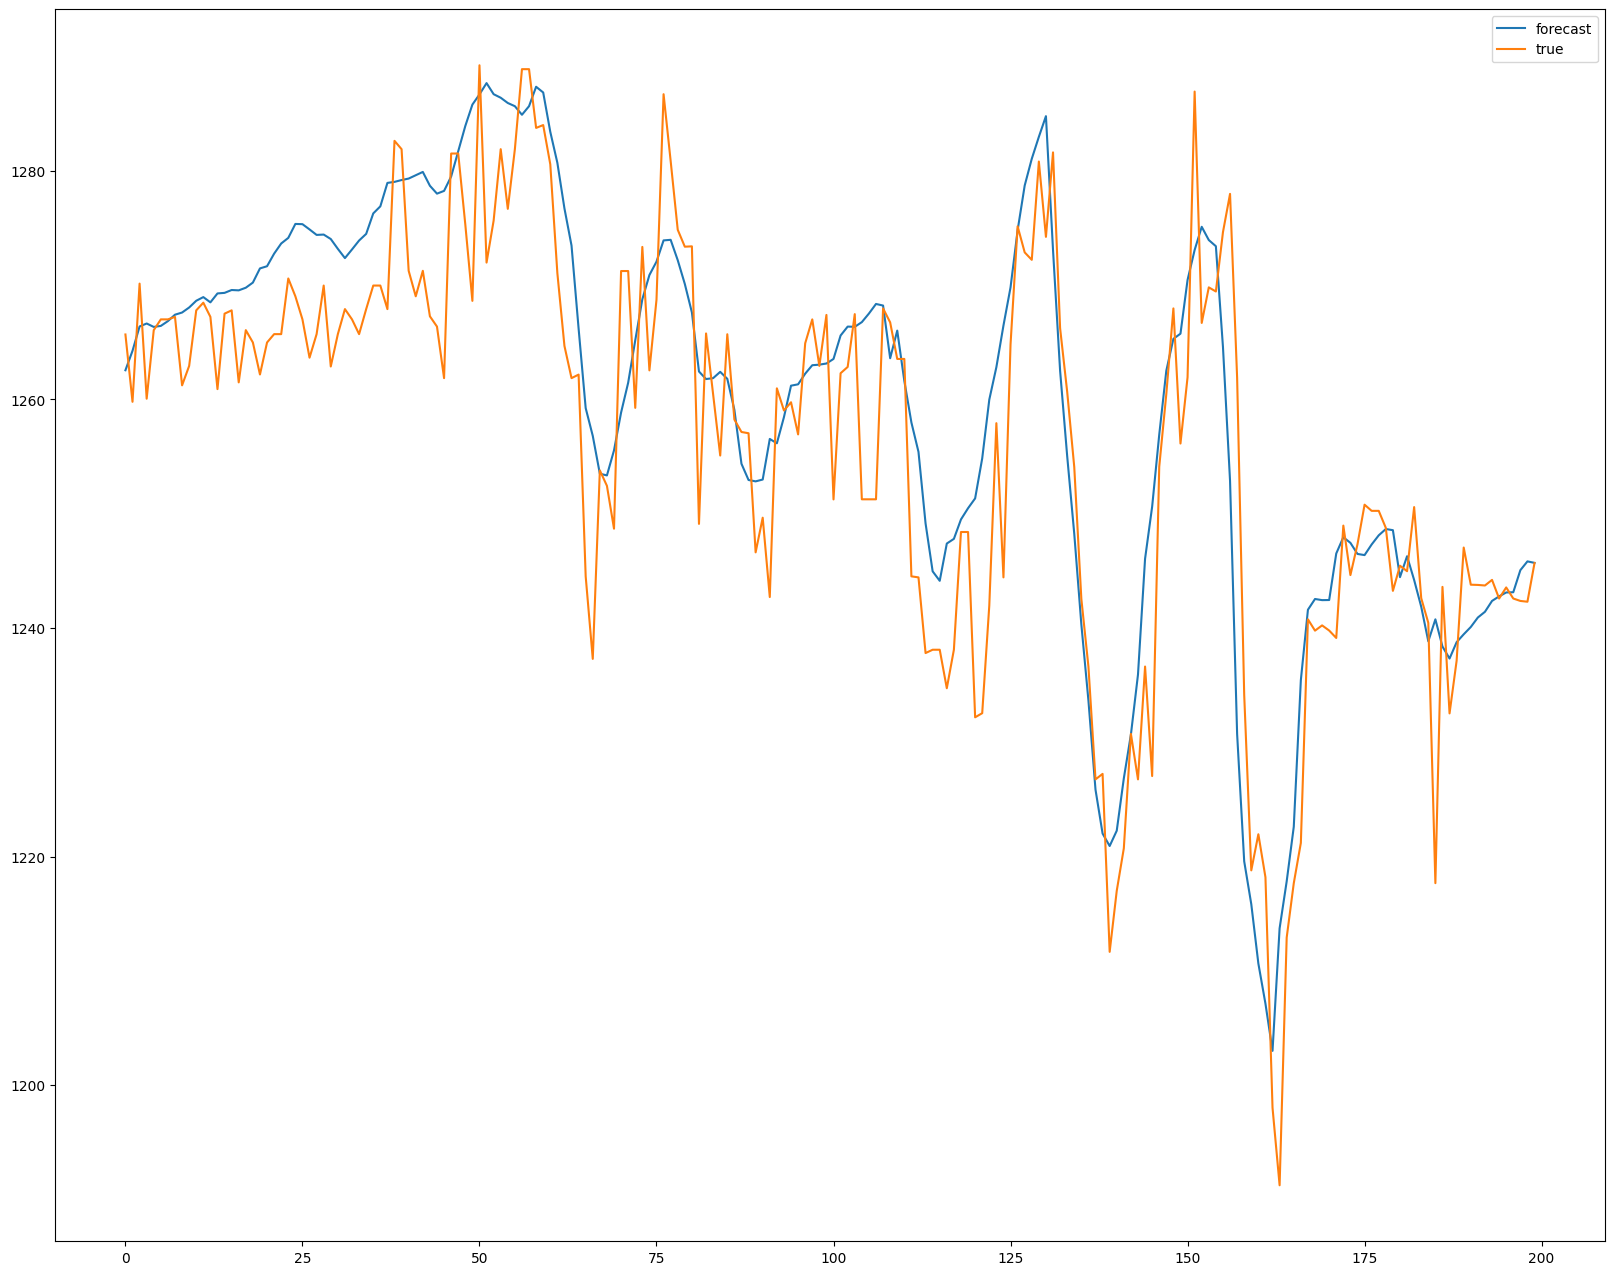

Analyzing predictions for wv (m/s)


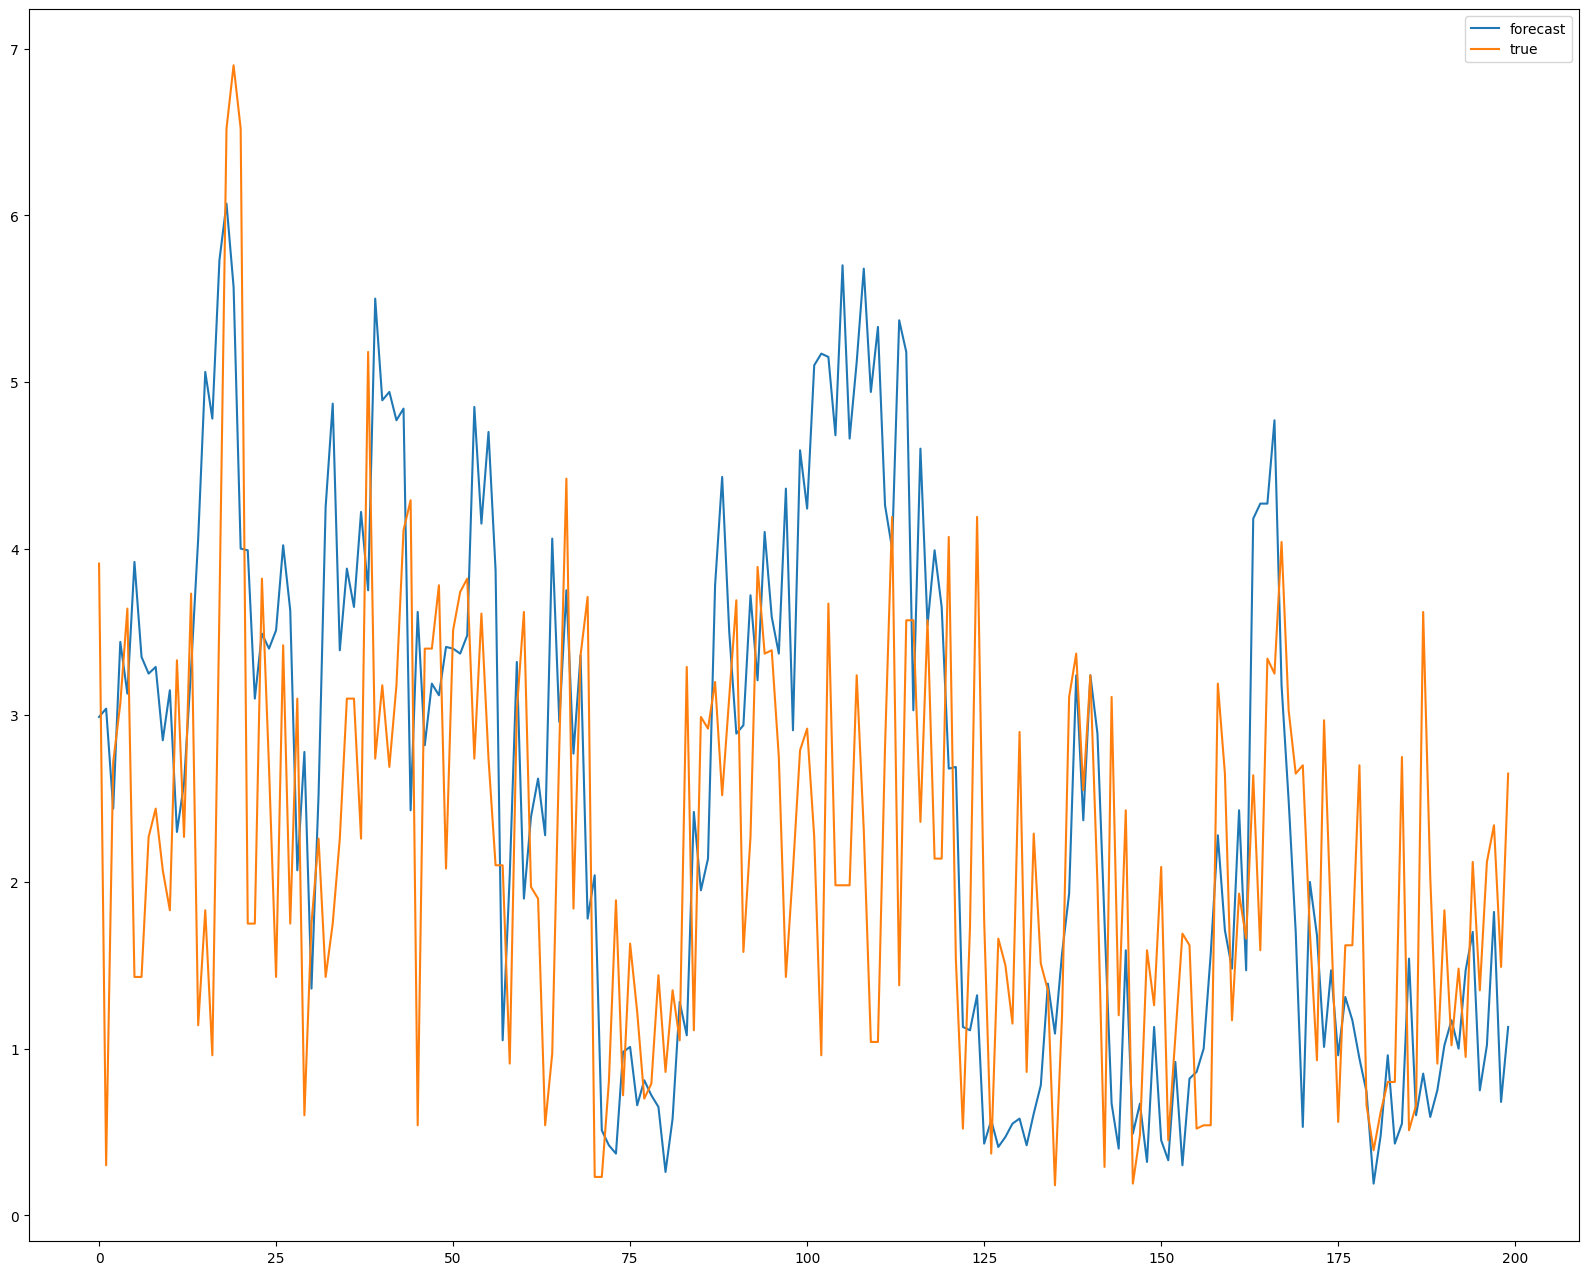

Analyzing predictions for max. wv (m/s)


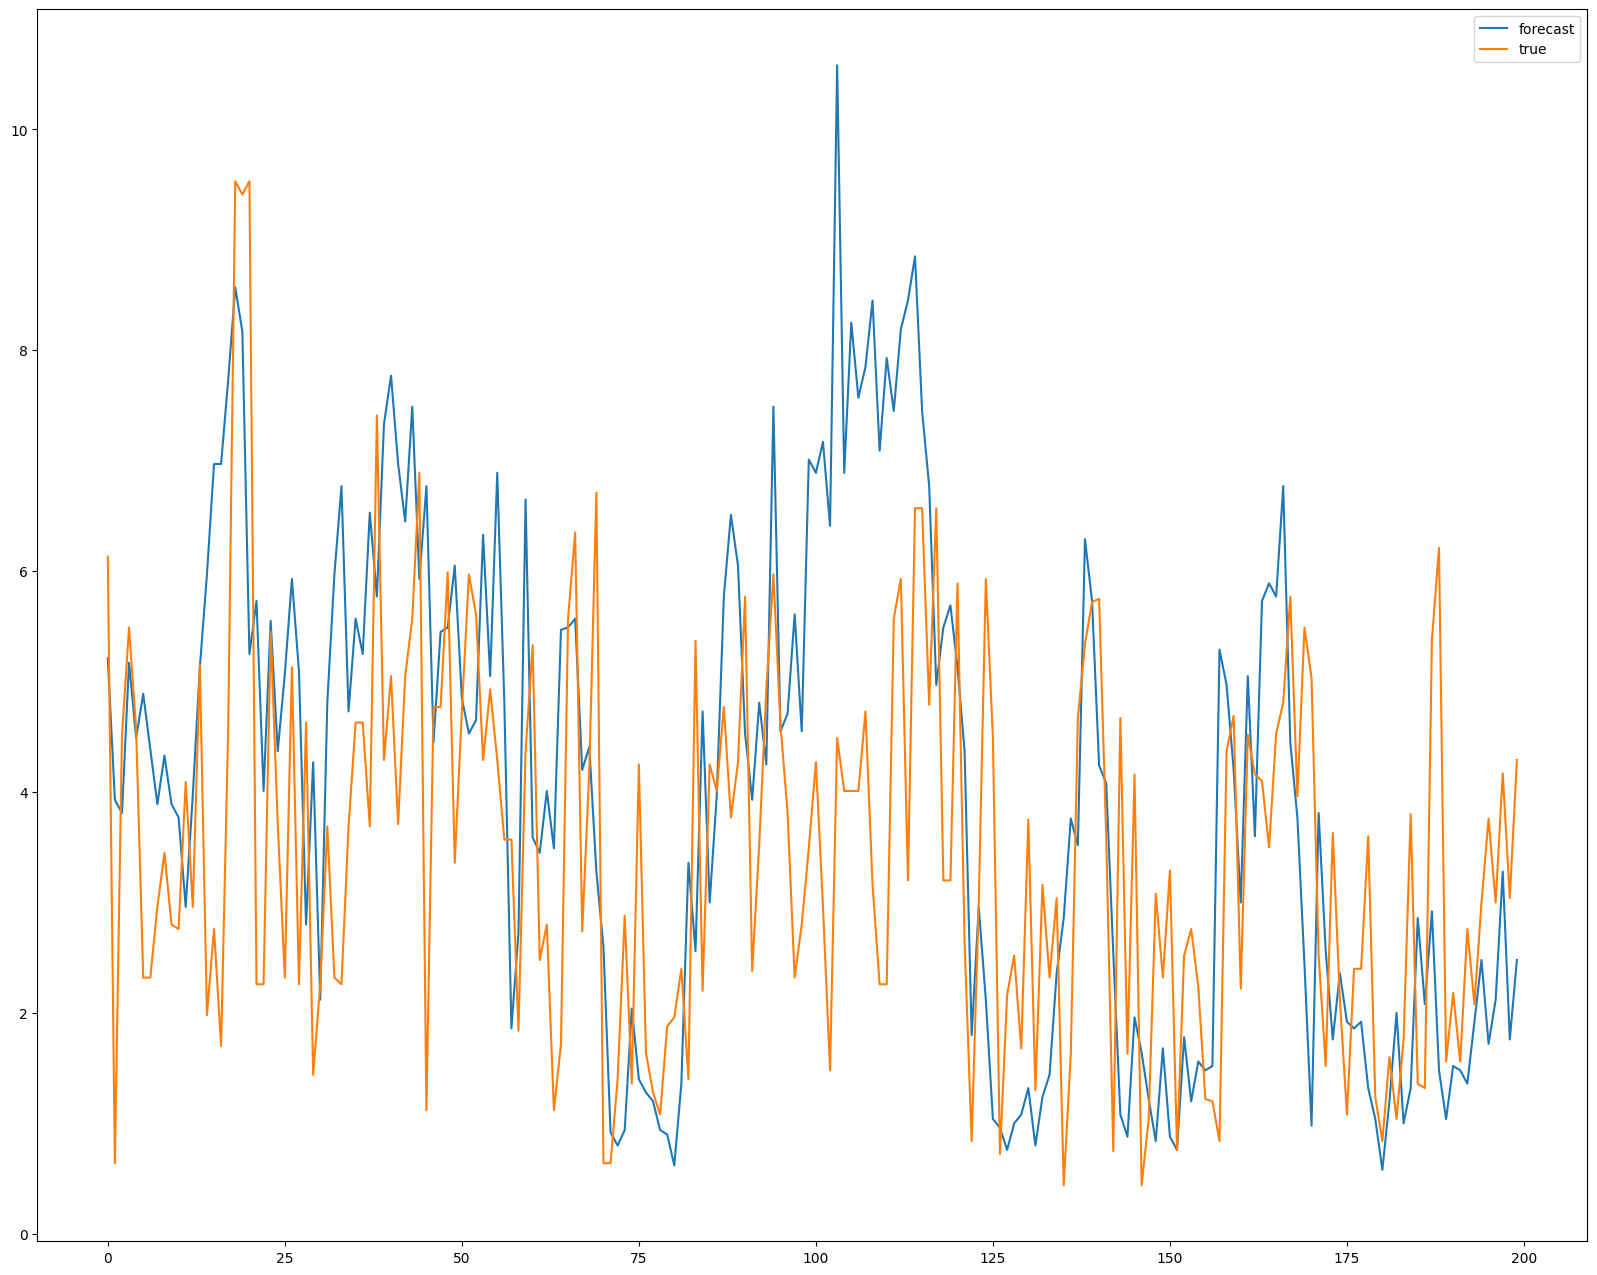

Analyzing predictions for wd (deg)


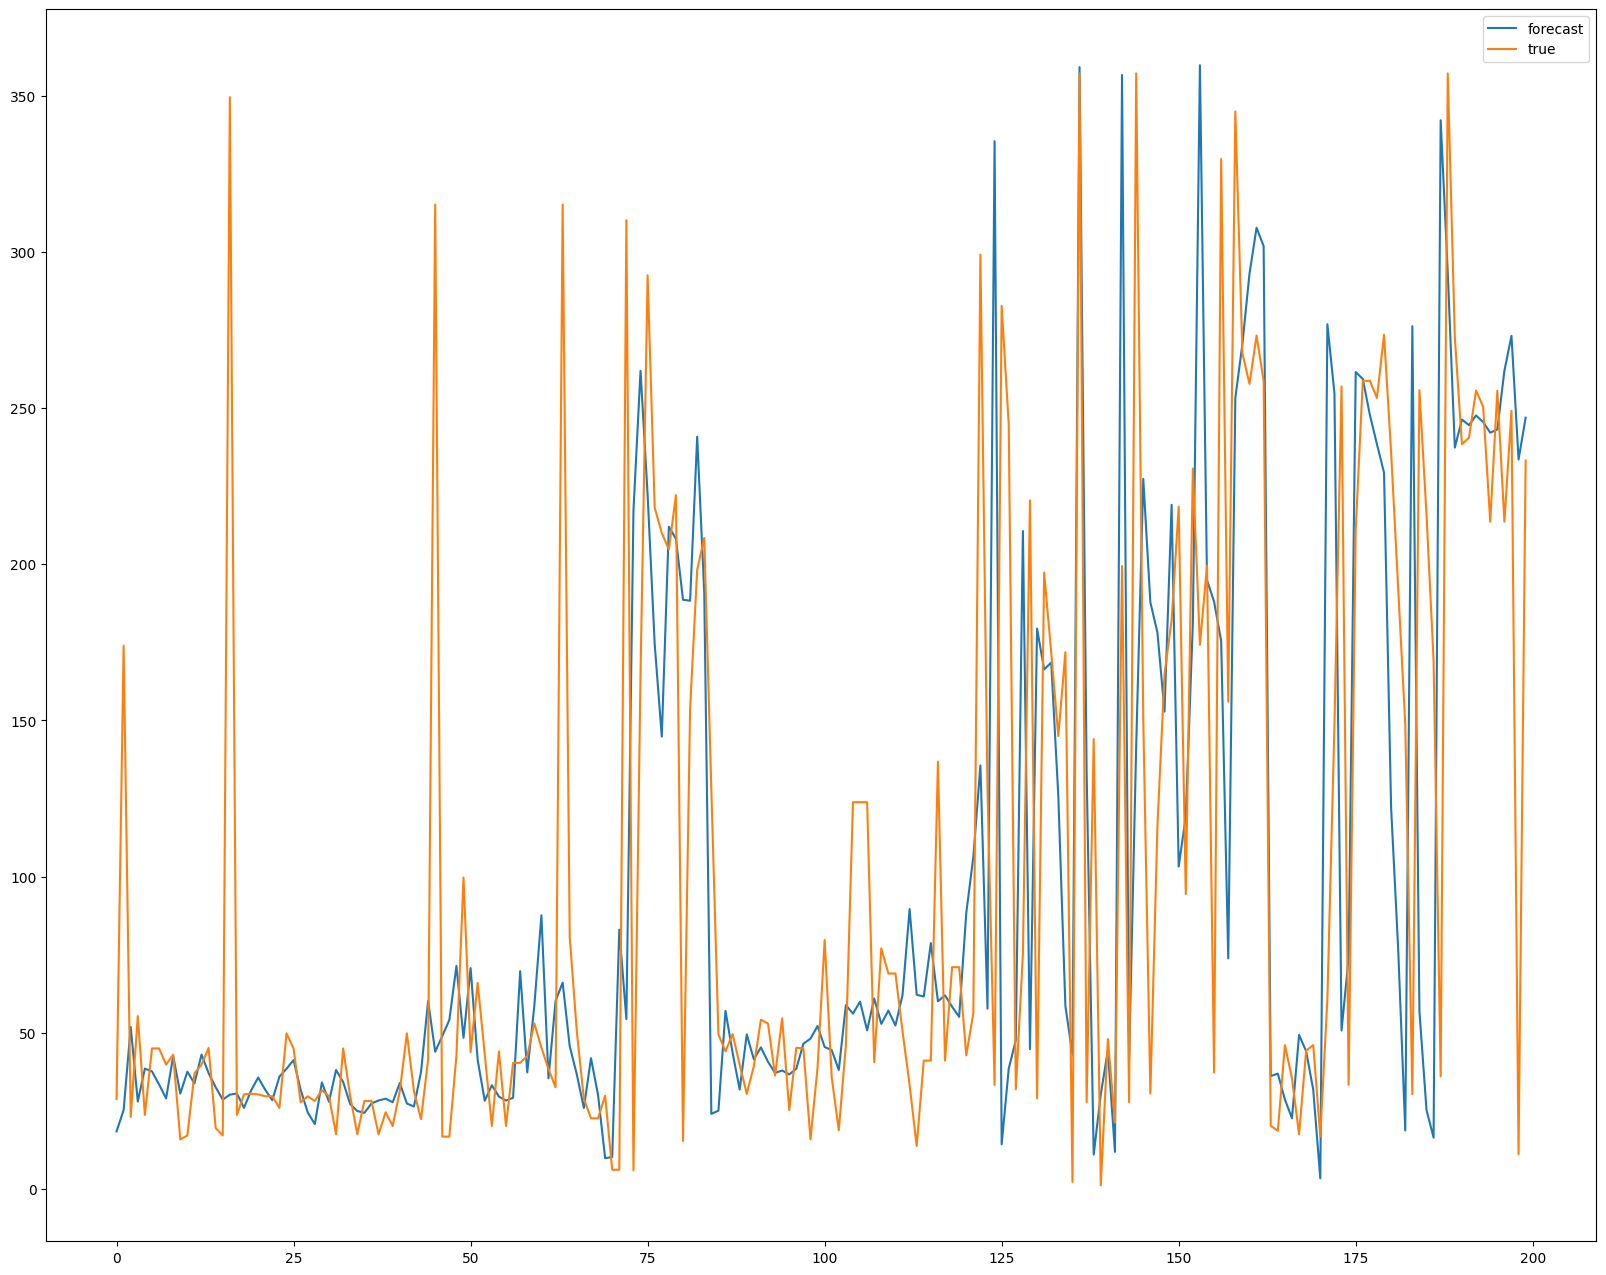

In [42]:
for feature in original_data_for_insert.columns[1:]:
    print(f'Analyzing predictions for {feature}')
    true_values, predicted_values = get_predictions(feature)
    plot_results(true_values, predicted_values)


### Summary

From the plots above we can see that the method is able to predict pretty accurately for feature like VPdef, VPmax, rh(%) etc. predict roughly accurately for features like H20C, rho and is not that great for features like wd, max.vv, wv. Given how simple the approach is and doesn't involve any feature engineering, it does pretty good in some spots!

We can improve these predictions by using more complex methods like LSTMs which are better suited to handle data like these.

### Delete the Index

Once we don't have use of the index we can delete them.


*Note: Index deletion is permanent*

In [43]:
pc.delete_index(index_name)